In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import ParameterGrid
import pickle

In [2]:
def sliding_window_forecast_with_scaling(df, target_col, model, model_name, model_params,
                                         window_size=25, test_ratio=0.2, drop_cols=None,
                                         log_dir="model_logs", log_filename="prediction_log.csv"):
    """
    Performs sliding window forecasting using standard scaling on both features and target.
    Inverse-transforms predictions back to original units before evaluation.
    Adds early stopping for XGBoost using test set as validation (only during tuning).
    """
    if drop_cols is None:
        drop_cols = []

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    log_path = os.path.join(log_dir, log_filename)
    log_entries = []

    df = df.dropna().sort_index()
    n = len(df)

    for start in range(0, n - window_size + 1):
        window_df = df.iloc[start:start + window_size].copy()
        X_window = window_df.drop(columns=[target_col] + drop_cols, errors='ignore')
        y_window = window_df[target_col].values

        train_size = int(len(X_window) * (1 - test_ratio))
        if train_size < 1 or train_size >= len(X_window):
            continue

        X_train = X_window.iloc[:train_size].values
        X_test = X_window.iloc[train_size:].values
        y_train = y_window[:train_size]
        y_test = y_window[train_size:]

        # Scale X
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale y
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Fit model on scaled X and y
        if model_name == "XGB":
            model.fit(X_train_scaled, y_train_scaled,
                      eval_set=[(X_test_scaled, y_test_scaled)], verbose=False
            )

        else:
            model.fit(X_train_scaled, y_train_scaled)

        # Predict
        y_pred_scaled = model.predict(X_test_scaled)

        # Inverse-transform prediction and test y
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

        # Evaluation
        mse = mean_squared_error(y_test_real, y_pred)
        mape = mean_absolute_percentage_error(y_test_real, y_pred)
        r2 = r2_score(y_test_real, y_pred)

        log_entry = {
            "model_name": model_name,
            "model_hyperparameters_dict": json.dumps(model_params),
            "window_size": window_size,
            "test_ratio": test_ratio,
            "start_date": str(df.index[start]),
            "end_date": str(df.index[start + window_size - 1]),
            "test_data_values_list": y_test_real.tolist(),
            "test_data_model_predictions_list": y_pred.tolist(),
            "MSE_score": mse,
            "MAPE_score": mape,
            "R^2_score": r2
        }
        log_entries.append(log_entry)

    log_df = pd.DataFrame(log_entries)
    if os.path.exists(log_path):
        existing = pd.read_csv(log_path)
        log_df = pd.concat([existing, log_df], ignore_index=True)
    log_df.to_csv(log_path, index=False)
    return log_df

In [3]:
def build_model(model_name, params):
    """
    Build a model given its type and hyperparameters.
    """
    if model_name == "RF":
        return RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    elif model_name == "SVM":
        return SVR(**params)
    elif model_name == "GB":
        return GradientBoostingRegressor(**params, random_state=42)
    elif model_name == "XGB":
        return xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    else:
        raise ValueError(f"Unknown model type: {model_name}")

In [4]:
def tune_model(df, target_col, model_type, param_grid, window_sizes=[25, 100, 200],
               test_ratio=0.2, drop_cols=None, log_dir="model_logs"):
    """
    Performs hyperparameter tuning for a single model type over the given window sizes.
    Uses a single tqdm progress bar that counts total iterations.
    
    Returns a combined summary DataFrame with:
      - model_name
      - model_hyperparameters_dict (JSON string)
      - window_size
      - test_ratio
      - avg_MSE
      - avg_MAPE
      - avg_R^2
    """
    if drop_cols is None:
        drop_cols = []
    
    # Calculate total iterations over all window sizes and hyperparam combinations.
    total_iterations = sum([len(list(ParameterGrid(param_grid))) for _ in window_sizes])
    pbar = tqdm(total=total_iterations, desc=f"Tuning {model_type}")
    
    summaries = []
    for window in window_sizes:
        for params in ParameterGrid(param_grid):
            model = build_model(model_type, params)
            log_df = sliding_window_forecast_with_scaling(
                df=df,
                target_col=target_col,
                model=model,
                model_name=model_type,
                model_params=params,  # Pass current parameter set.
                window_size=window,
                test_ratio=test_ratio,
                drop_cols=drop_cols,
                log_dir=log_dir,
                log_filename=f"{model_type}_window_{window}.csv"
            )
            pbar.update(1)
            if log_df.empty:
                continue
            avg_mse = log_df["MSE_score"].mean()
            avg_mape = log_df["MAPE_score"].mean()
            avg_r2 = log_df["R^2_score"].mean()
            summary_entry = {
                "model_name": model_type,
                "model_hyperparameters_dict": json.dumps(params),
                "window_size": window,
                "test_ratio": test_ratio,
                "avg_MSE": avg_mse,
                "avg_MAPE": avg_mape,
                "avg_R^2": avg_r2
            }
            summaries.append(summary_entry)
    pbar.close()
    if summaries:
        combined_summary = pd.DataFrame(summaries)
        return combined_summary
    else:
        return pd.DataFrame()

In [5]:
def combine_and_top_logs(log_dir="model_logs", tops=5):
    """
    Reads all CSV files in the given log directory (matching *_window*.csv),
    combines them into a single DataFrame, groups by model_name and hyperparameter
    configuration, then computes the average MSE, MAPE, and R^2.
    Returns a DataFrame containing the top 5 configurations (by MAPE)
    for each model type.
    """
    # List all CSV files in the log directory
    all_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    dfs = [pd.read_csv(f) for f in all_files]
    combined_logs = pd.concat(dfs, ignore_index=True)
    
    # Group by model_name and hyperparameters and compute average metrics
    grouped_summary = combined_logs.groupby(
        ["model_name", "model_hyperparameters_dict"]
    )[["MSE_score", "MAPE_score", "R^2_score"]].mean().reset_index()
    
    # For each model, get the top five (lowest MAPE)
    top_n_list = []
    for model in grouped_summary["model_name"].unique():
        top_n = grouped_summary[grouped_summary["model_name"] == model].sort_values("MAPE_score", ascending=True).head(tops)
        top_n_list.append(top_n)
        
    top_n_combined = pd.concat(top_n_list, ignore_index=True)
    return top_n_combined

In [6]:
param_grids = {
    "RF": {
        "n_estimators": [1000, 1250, 1500, 1750, 2000],
        "max_depth": [8, 10, 12],
        "min_samples_split": [2, 3],
        "max_features": ["sqrt", "log2", 0.5],
        "bootstrap": [True, False],

    },
    "SVM": {
        "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 2.55, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5],
        "epsilon": [1e-5, 1.5e-5, 2e-5, 2.5e-5, 3e-5, 3.5e-5, 4e-5, 4.5e-5, 5e-5],
        "kernel": ["rbf", "poly", "sigmoid", "linear"],
    },
    "GB": {
        "n_estimators": [1600, 3200, 4800, 6400, 8000],
        "learning_rate": [0.0025, 0.005, 0.01, 0.02, 0.04],
        "max_depth": [2],
        "subsample": [0.5, 0.55, 0.6, 0.66, 0.73, 0.81, 0.9],
    },
    "XGB": {
        "n_estimators": [1600, 3200, 4800, 6400, 8000],
        "learning_rate": [0.0025, 0.005, 0.01, 0.02, 0.04],
        "max_depth": [2],
        "subsample": [0.8, 0.9, 1],
        "colsample_bytree": [0.6, 0.8, 1],
        "early_stopping_rounds": [32],
    }
}

In [7]:
with open("temp_output/quarterly_X_y.pkl", "rb") as f:
    data_q = pickle.load(f)

drop_columns = []
print(data_q.keys())  # Should show all the tickers like AAPL, MSFT, etc.
quaterly_data = data_q["AAPL"]

dict_keys(['AAPL', 'MSFT', 'LLY', 'UNH', 'V', 'MA', 'GOOGL', 'META', 'AMZN', 'TSLA', 'PG', 'WMT', 'RTX', 'UNP', 'XOM', 'CVX', 'LIN', 'SHW', 'AMT', 'PLD', 'NEE', 'SO'])


In [8]:
rf_summary_q = tune_model(quaterly_data, target_col="y", model_type="RF",
                          param_grid=param_grids["RF"],
                          window_sizes=[10], #[25, 100, 200],
                          test_ratio=0.2, drop_cols=drop_columns,
                          log_dir="model_logs_q")

svm_summary_q = tune_model(quaterly_data, target_col="y", model_type="SVM",
                           param_grid=param_grids["SVM"],
                           window_sizes=[10], #[25, 100, 200],
                           test_ratio=0.2, drop_cols=drop_columns,
                           log_dir="model_logs_q")

gb_summary_q = tune_model(quaterly_data, target_col="y", model_type="GB",
                          param_grid=param_grids["GB"],
                          window_sizes=[10], #[25, 100, 200],
                          test_ratio=0.2, drop_cols=drop_columns,
                          log_dir="model_logs_q")

xgb_summary_q = tune_model(quaterly_data, target_col="y", model_type="XGB",
                           param_grid=param_grids["XGB"],
                           window_sizes=[10], #[25, 100, 200],
                           test_ratio=0.2, drop_cols=drop_columns,
                           log_dir="model_logs_q")

Tuning XGB: 100%|██████████| 225/225 [2:18:03<00:00, 36.82s/it]  


In [9]:
combined_summary_q = pd.concat([rf_summary_q, svm_summary_q, gb_summary_q, xgb_summary_q], ignore_index=True)
print("Combined Tuning Summary:")
display(combined_summary_q)

# Alternatively, read all prediction log files from log directory
top5_summary_q = combine_and_top_logs(log_dir="model_logs_q")
print("Top 5 Configurations per Model:")
display(top5_summary_q)

Combined Tuning Summary:


,model_name,model_hyperparameters_dict,window_size,test_ratio,avg_MSE,avg_MAPE,avg_R^2
0,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",10,0.2,829.134764,0.191411,-242.121456
1,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",10,0.2,825.303108,0.191138,-241.482917
2,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",10,0.2,823.464689,0.191023,-241.182973
3,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",10,0.2,823.222241,0.191006,-240.935827
4,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",10,0.2,822.565663,0.190878,-240.578065
...,...,...,...,...,...,...,...
1079,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",10,0.2,538.495244,0.142693,-99.109481
1080,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",10,0.2,538.495890,0.142689,-99.029041
1081,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",10,0.2,538.406263,0.142676,-99.051060
1082,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",10,0.2,538.276283,0.142662,-98.979272


Top 5 Configurations per Model:


,model_name,model_hyperparameters_dict,MSE_score,MAPE_score,R^2_score
0,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",680.701126,0.173934,-217.582112
1,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",680.701127,0.173934,-217.582112
2,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",680.701127,0.173934,-217.582112
3,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",680.701827,0.173934,-217.582067
4,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",681.148739,0.173996,-217.573701
5,RF,"{""bootstrap"": false, ""max_depth"": 10, ""max_fea...",690.213557,0.171689,-192.918805
6,RF,"{""bootstrap"": false, ""max_depth"": 12, ""max_fea...",690.213557,0.171689,-192.918805
7,RF,"{""bootstrap"": false, ""max_depth"": 8, ""max_feat...",690.213557,0.171689,-192.918805
8,RF,"{""bootstrap"": false, ""max_depth"": 12, ""max_fea...",695.305421,0.171805,-193.977412
9,RF,"{""bootstrap"": false, ""max_depth"": 10, ""max_fea...",695.305421,0.171805,-193.977412


In [10]:
with open("temp_output/daily_X_y.pkl", "rb") as f:
    data_d = pickle.load(f)
    
drop_columns = []
print(data_d.keys())  # Should show all the tickers like AAPL, MSFT, etc.
daily_data = data_d["AAPL"]
daily_data = daily_data.iloc[-128:,:]
daily_data

dict_keys(['AAPL', 'MSFT', 'LLY', 'UNH', 'V', 'MA', 'GOOGL', 'META', 'AMZN', 'TSLA', 'PG', 'WMT', 'RTX', 'UNP', 'XOM', 'CVX', 'LIN', 'SHW', 'AMT', 'PLD', 'NEE', 'SO', '^GSPC'])


,Adj Close,Close,High,Low,Open,Volume,SMA5,SMA50,SMA200,MACDLine,...,^IXIC,^DJI,^VIX,CL=F,GC=F,SI=F,^TNX,DX-Y.NYB,FedFundsRate,y
2024-07-01,216.023956,216.750000,217.509995,211.919998,212.089996,60402900,212.045337,190.963963,182.925128,6.332361,...,17879.300781,39169.519531,12.22,83.379997,2327.600098,29.299999,4.479,105.900002,5.33,219.532166
2024-07-02,219.532166,220.270004,220.380005,215.100006,216.149994,58046200,214.277832,192.070115,183.150482,6.644231,...,18028.759766,39331.851562,12.03,82.809998,2323.000000,29.353001,4.436,105.720001,5.33,220.807877
2024-07-03,220.807877,221.550003,221.550003,219.029999,220.000000,37369800,215.932269,193.185061,183.385838,6.914622,...,18188.300781,39308.000000,12.09,83.879997,2359.800049,30.548000,4.355,105.400002,5.33,225.581833
2024-07-05,225.581833,226.339996,226.449997,221.649994,221.649994,60412400,218.372064,194.374385,183.630372,7.428496,...,18352.759766,39375.871094,12.48,83.160004,2388.500000,31.388000,4.272,104.879997,5.33,227.056885
2024-07-08,227.056885,227.820007,227.850006,223.250000,227.089996,59085900,221.800543,195.551010,183.876821,7.864116,...,18403.740234,39344.789062,12.37,82.330002,2355.199951,30.618000,4.269,105.010002,5.33,227.913986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,257.916443,258.200012,258.209991,255.289993,255.490005,23234700,252.881967,235.564016,211.182570,6.067327,...,20031.130859,43297.031250,14.27,70.099998,2620.000000,29.974001,4.591,108.260002,4.33,258.735504
2024-12-26,258.735504,259.019989,260.100006,257.630005,258.190002,27237100,255.073553,236.071997,211.614168,6.300019,...,20020.359375,43325.800781,14.73,69.620003,2638.800049,30.047001,4.579,108.129997,4.33,255.309296
2024-12-27,255.309296,255.589996,258.700012,253.059998,257.829987,42355300,256.232281,236.552763,212.039086,6.137217,...,19722.029297,42992.210938,15.95,70.599998,2617.199951,29.655001,4.619,108.000000,4.33,251.923019
2024-12-30,251.923019,252.199997,253.500000,250.750000,252.229996,35557500,255.774783,236.958420,212.437766,5.669595,...,19486.789062,42573.730469,17.40,70.989998,2606.100098,29.106001,4.545,108.129997,4.33,250.144974


In [11]:
rf_summary_d = tune_model(daily_data, target_col="y", model_type="RF",
                        param_grid=param_grids["RF"],
                        window_sizes=[25], #[25, 100, 200],
                        test_ratio=0.2, drop_cols=drop_columns,
                        log_dir="model_logs_d")

svm_summary_d = tune_model(daily_data, target_col="y", model_type="SVM",
                            param_grid=param_grids["SVM"],
                        window_sizes=[25], #[25, 100, 200],
                            test_ratio=0.2, drop_cols=drop_columns,
                            log_dir="model_logs_d")

gb_summary_d = tune_model(daily_data, target_col="y", model_type="GB",
                        param_grid=param_grids["GB"],
                        window_sizes=[25], #[25, 100, 200],
                        test_ratio=0.2, drop_cols=drop_columns,
                        log_dir="model_logs_d")

xgb_summary_d = tune_model(daily_data, target_col="y", model_type="XGB",
                            param_grid=param_grids["XGB"],
                        window_sizes=[25], #[25, 100, 200],
                            test_ratio=0.2, drop_cols=drop_columns,
                            log_dir="model_logs_d")

Tuning XGB: 100%|██████████| 225/225 [4:46:31<00:00, 76.41s/it]   


In [12]:
combined_summary_d = pd.concat([rf_summary_d, svm_summary_d, gb_summary_d, xgb_summary_d], ignore_index=True)
print("Combined Tuning Summary:")
display(combined_summary_d)

# Alternatively, read all prediction log files from log directory
top5_summary_d = combine_and_top_logs(log_dir="model_logs_d")
print("Top 5 Configurations per Model:")
display(top5_summary_d)

Combined Tuning Summary:


,model_name,model_hyperparameters_dict,window_size,test_ratio,avg_MSE,avg_MAPE,avg_R^2
0,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",25,0.2,23.646202,0.016722,-6.701624
1,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",25,0.2,23.591764,0.016701,-6.684631
2,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",25,0.2,23.581478,0.016692,-6.665451
3,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",25,0.2,23.575353,0.016686,-6.655876
4,RF,"{""bootstrap"": true, ""max_depth"": 8, ""max_featu...",25,0.2,23.577619,0.016685,-6.652851
...,...,...,...,...,...,...,...
1079,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",25,0.2,17.594313,0.014478,-4.042374
1080,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",25,0.2,17.591054,0.014477,-4.041050
1081,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",25,0.2,17.590907,0.014477,-4.040748
1082,XGB,"{""colsample_bytree"": 1, ""early_stopping_rounds...",25,0.2,17.589798,0.014476,-4.040116


Top 5 Configurations per Model:


,model_name,model_hyperparameters_dict,MSE_score,MAPE_score,R^2_score
0,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",25.817504,0.017452,-8.095856
1,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",25.867423,0.017465,-8.106405
2,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",25.871010,0.017466,-8.106838
3,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",25.871283,0.017467,-8.106845
4,GB,"{""learning_rate"": 0.005, ""max_depth"": 2, ""n_es...",25.871308,0.017467,-8.106846
5,RF,"{""bootstrap"": false, ""max_depth"": 8, ""max_feat...",22.301745,0.016134,-6.670219
6,RF,"{""bootstrap"": false, ""max_depth"": 10, ""max_fea...",22.307296,0.016138,-6.665439
7,RF,"{""bootstrap"": false, ""max_depth"": 8, ""max_feat...",22.336189,0.016138,-6.637178
8,RF,"{""bootstrap"": false, ""max_depth"": 12, ""max_fea...",22.309251,0.016139,-6.666561
9,RF,"{""bootstrap"": false, ""max_depth"": 8, ""max_feat...",22.296398,0.016140,-6.690037


In [8]:
top_summary_q = combine_and_top_logs(log_dir="model_logs_q", tops=25)
for d in top_summary_q['model_hyperparameters_dict']:
    print(json.loads(d))
    
print("="*100)

top_summary_d = combine_and_top_logs(log_dir="model_logs_d", tops=25)
for d in top_summary_d['model_hyperparameters_dict']:
    print(json.loads(d))

{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 8000, 'subsample': 0.9}
{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 6400, 'subsample': 0.9}
{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 4800, 'subsample': 0.9}
{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 3200, 'subsample': 0.9}
{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 1600, 'subsample': 0.9}
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 4800, 'subsample': 0.9}
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 3200, 'subsample': 0.9}
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 8000, 'subsample': 0.9}
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 6400, 'subsample': 0.9}
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1600, 'subsample': 0.9}
{'learning_rate': 0.0025, 'max_depth': 2, 'n_estimators': 8000, 'subsample': 0.9}
{'learning_rate': 0.0025, 'max_depth': 2, 'n_estimators': 6400, 'subsample': 0.9}
{'learning_rate': 0.0025, 'max_

In [47]:
def combine_and_top_logs(log_dir="model_logs", tops=5):
    all_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    dfs = [pd.read_csv(f) for f in all_files]
    combined_logs = pd.concat(dfs, ignore_index=True)
    
    grouped_summary = combined_logs.groupby(
        ["model_name", "model_hyperparameters_dict"]
    )[["MSE_score", "MAPE_score", "R^2_score"]].mean().reset_index()
    
    top_n_list = []
    for model in grouped_summary["model_name"].unique():
        top_n = grouped_summary[grouped_summary["model_name"] == model].sort_values("MAPE_score", ascending=True).head(tops)
        top_n_list.append(top_n)
        
    top_n_combined = pd.concat(top_n_list, ignore_index=True)
    return top_n_combined

# Load top logs
top_summary_q = combine_and_top_logs(log_dir="model_logs_q", tops=10000)
top_summary_d = combine_and_top_logs(log_dir="model_logs_d", tops=10000)

top_summary_q["range"] = "q"
top_summary_d["range"] = "d"

# Merge both and filter for SVM only
combined_top_summary = pd.concat([top_summary_q, top_summary_d], ignore_index=True)
svm_rows = combined_top_summary[combined_top_summary["model_name"] == "SVM"].copy()

# Parse the hyperparameter dictionary JSON strings
svm_rows["hyperparams"] = svm_rows["model_hyperparameters_dict"].apply(json.loads)
svm_rows = svm_rows.reset_index(drop=True)

# Flatten the hyperparameters into columns
hyperparam_df = pd.json_normalize(svm_rows["hyperparams"])
svm_results = pd.concat([svm_rows, hyperparam_df], axis=1)
svm_results = svm_results.drop(columns=["model_hyperparameters_dict", "hyperparams"])

svm_results = svm_results.sort_values("MAPE_score").reset_index(drop=True)
svm_results.to_csv("svm_results")
svm_results

,model_name,MSE_score,MAPE_score,R^2_score,range,C,epsilon,kernel
0,SVM,20.508010,0.015311,-5.117016,d,0.5,0.000030,sigmoid
1,SVM,20.508014,0.015311,-5.117009,d,0.5,0.000025,sigmoid
2,SVM,20.508078,0.015311,-5.117002,d,0.5,0.000010,sigmoid
3,SVM,20.508138,0.015311,-5.117076,d,0.5,0.000015,sigmoid
4,SVM,20.508234,0.015311,-5.117140,d,0.5,0.000020,sigmoid
...,...,...,...,...,...,...,...,...
1003,SVM,10471.661289,0.510051,-9563.755899,q,6.5,0.000030,poly
1004,SVM,10471.839339,0.510053,-9563.829050,q,6.5,0.000025,poly
1005,SVM,10472.017702,0.510055,-9563.902214,q,6.5,0.000020,poly
1006,SVM,10472.196069,0.510057,-9563.975379,q,6.5,0.000015,poly


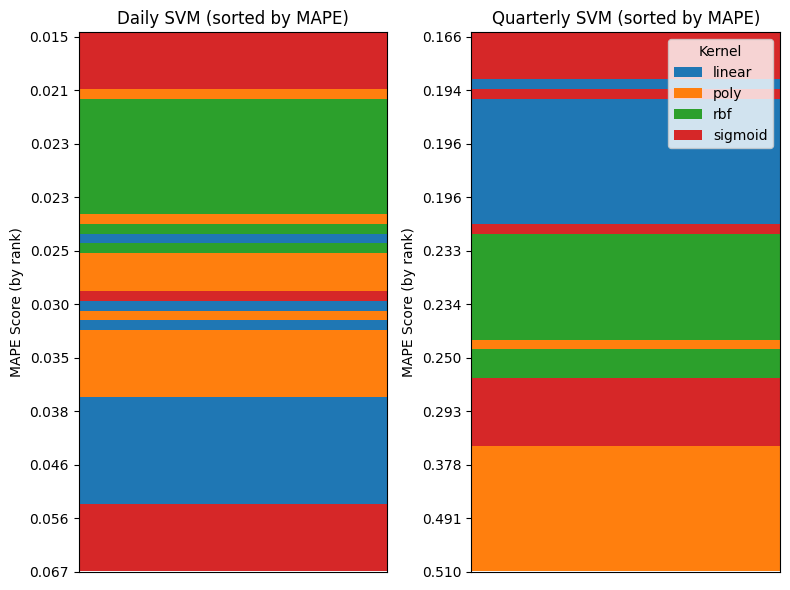

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# -- Assume that svm_results is produced as in your code --
# For this example, we assume svm_results is already available.
# It should have at least columns: "range", "MAPE_score", and "kernel"
# with "range" either "d" (daily) or "q" (quarterly),
# and kernel strings like "linear", "poly", "rbf", or "sigmoid".

# Define the kernel-to-color mapping and an ordering
kernel_order = ["linear", "poly", "rbf", "sigmoid"]
kernel_colors = {
    "linear": "#1f77b4",
    "poly": "#ff7f0e",
    "rbf": "#2ca02c",
    "sigmoid": "#d62728"
}
# Map kernel to integer code based on order
kernel_to_int = {k: i for i, k in enumerate(kernel_order)}
# Create a ListedColormap based on our ordered colors
cmap = ListedColormap([kernel_colors[k] for k in kernel_order])

# Separate the data into daily and quarterly groups (assume sorted by MAPE already)
daily = svm_results[svm_results["range"] == "d"].sort_values("MAPE_score", ascending=False).reset_index(drop=True)
quarterly = svm_results[svm_results["range"] == "q"].sort_values("MAPE_score", ascending=False).reset_index(drop=True)

def create_stripe_image(df):
    """
    Given a DataFrame sorted by MAPE, return a 2D array with one column.
    Each row is assigned the integer code corresponding to its kernel.
    """
    n = len(df)
    # Map kernel column to integer codes
    codes = df["kernel"].map(kernel_to_int).values.reshape(n, 1)
    return codes

# Create the stripe arrays
daily_stripe = create_stripe_image(daily)
quarterly_stripe = create_stripe_image(quarterly)

# Decide tick interval (adjust as needed)
tick_interval = max(1, len(daily) // 10)  # e.g. every ~10 models

# Create a figure with two subplots (side-by-side)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

def plot_stripe(ax, stripe, df, title):
    n = stripe.shape[0]
    # We use imshow to display the stripe.
    # The extent is set so that the y-axis goes from 0 to n.
    im = ax.imshow(stripe, aspect="auto", interpolation="none", 
                   cmap=cmap, extent=[0, 1, 0, n], origin="lower")
    ax.set_title(title)
    ax.set_xticks([])  # no x-axis ticks for the stripe
    
    # Set y-ticks every tick_interval. Get the corresponding MAPE values.
    ticks = np.arange(0, n, tick_interval)
    tick_labels = [f"{df.iloc[i]['MAPE_score']:.3f}" for i in ticks]
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_ylabel("MAPE Score (by rank)")
    
# Plot for daily and quarterly
plot_stripe(axs[0], daily_stripe, daily, "Daily SVM (sorted by MAPE)")
plot_stripe(axs[1], quarterly_stripe, quarterly, "Quarterly SVM (sorted by MAPE)")

# Create a custom legend for the kernel colors
legend_elements = [Patch(facecolor=kernel_colors[k], label=k) for k in kernel_order]
axs[1].legend(handles=legend_elements, title="Kernel", loc="upper right")

plt.tight_layout()
plt.show()
